In [ ]:
# This is the template for the submission. If you want, you can develop your algorithm in a regular Python script and copy the code here for submission.

# Team members (e-mail, legi):
# zhisun@ethz.ch, 22-958-227
# enjcao@ethz.ch, 22-942-700
# yifzhou@ethz.ch, 22-940-381

In [118]:
import pandas as pd
import math
from Lilygo.Recording import Recording
from Lilygo.Dataset import Dataset
from os import listdir
from os.path import isfile, join
from math import sqrt
import numpy as np
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt

In [119]:
# Get the path of all traces
dir_traces = './data/labeled_traces'
filenames = [join(dir_traces, f) for f in listdir(dir_traces) if isfile(join(dir_traces, f))]
filenames.sort()
print(filenames)

['./data/labeled_traces\\labeled_trace_01.json', './data/labeled_traces\\labeled_trace_02.json', './data/labeled_traces\\labeled_trace_03.json', './data/labeled_traces\\labeled_trace_04.json', './data/labeled_traces\\labeled_trace_05.json', './data/labeled_traces\\labeled_trace_06.json', './data/labeled_traces\\labeled_trace_07.json', './data/labeled_traces\\labeled_trace_08.json', './data/labeled_traces\\labeled_trace_09.json', './data/labeled_traces\\labeled_trace_10.json']


In [135]:
def get_peaks(input_signal, prominence):
    peak_locations, _ = sp.signal.find_peaks(input_signal, prominence=prominence)
    peak_values = input_signal[peak_locations]
    # valley_locations = sp.signal.find_peaks(-input_signal, height=min_peak_height)
    # valley_values = input_signal[valley_locations]
    return peak_locations, peak_values

In [121]:
def normalize(signal, min_peak_height):#, z_threshold, valley_values):
    # Find maximum among all peak values except outlier peaks
    peak_locations, peak_values = get_peaks(signal, min_peak_height)
    # outlier_locations, outlier_values = get_outliers(signal, z_threshold)
    max_candidates = peak_values #-outlier_values
    mx = np.max(max_candidates)
    
    # Find minimum all valley values except outlier valleys
    valley_locations, valley_values = get_peaks(-signal, min_peak_height)
    # voutlier_locations, voutlier_values = get_outliers(-signal, z_threshold)
    min_candidates = valley_values #-voutlier_values
    mn = -np.max(min_candidates)
    
    #normalize signal 
    normalized_signal = np.true_divide((signal-mn), (mx-mn), out=np.zeros_like(signal), where=(mx-mn)!=0)

    
    return normalized_signal - 0.5

In [142]:
class Filter:
    @staticmethod
    def low_0_hz(data):
        COEFFICIENTS_LOW_0_HZ = {
            'alpha': [1, -1.979133761292768, 0.979521463540373],
            'beta': [0.000086384997973502, 0.00012769995947004, 0.000086384997973502]
        }
        return Filter.filter(data, COEFFICIENTS_LOW_0_HZ)

    @staticmethod
    def low_5_hz(data):
        COEFFICIENTS_LOW_5_HZ = {
            'alpha': [1, -1.80898117793047, 0.827224480562408],
            'beta': [0.096665967120306, -0.172688631608676, 0.095465967120306]
        }
        return Filter.filter(data, COEFFICIENTS_LOW_5_HZ)

    @staticmethod
    def high_1_hz(data):
        COEFFICIENTS_HIGH_1_HZ = {
            'alpha': [1, -1.905384612118461, 0.910092542787947],
            'beta': [0.953986986993339, -1.907503180919730, 0.953986986993339]
        }
        return Filter.filter(data, COEFFICIENTS_HIGH_1_HZ)

    @staticmethod
    def filter(data, coef):
        fd = np.zeros_like(data)  # filtered_data

        for i in range(2, len(data)):
            fd[i] = coef['alpha'][0] * (data[i] * coef['beta'][0]
                                        + data[i-1] * coef['beta'][1]
                                        + data[i-2] * coef['beta'][2]
                                        - fd[i-1] * coef['alpha'][1]
                                        - fd[i-2] * coef['alpha'][2])
        return fd

In [ ]:
# read labels.csv
labels_csv = pd.read_csv('./data/labels.csv')

StepCount: 98  Expected: 101


d:\anaconda3\envs\mhealth23\lib\site-packages\ipykernel_launcher.py:94: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "y+" (-> color='y'). The keyword argument will take precedence.


StepCount: 100  Expected: 101
StepCount: 103  Expected: 102
StepCount: 101  Expected: 101
StepCount: 51  Expected: 52
StepCount: 42  Expected: 47
StepCount: 47  Expected: 43
StepCount: 66  Expected: 61
StepCount: 47  Expected: 49
StepCount: 61  Expected: 75
Error:  1.4


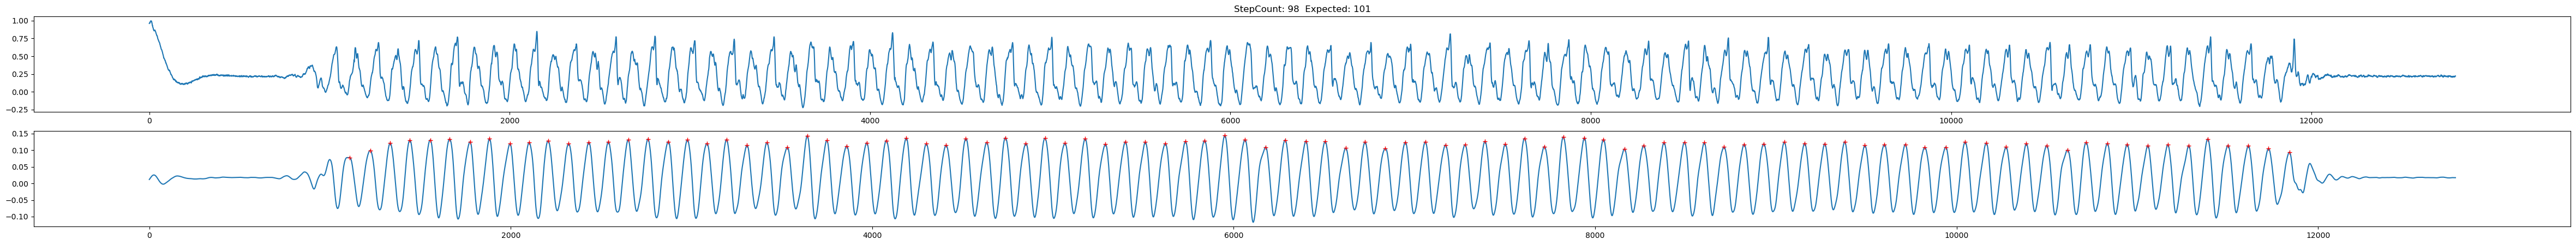

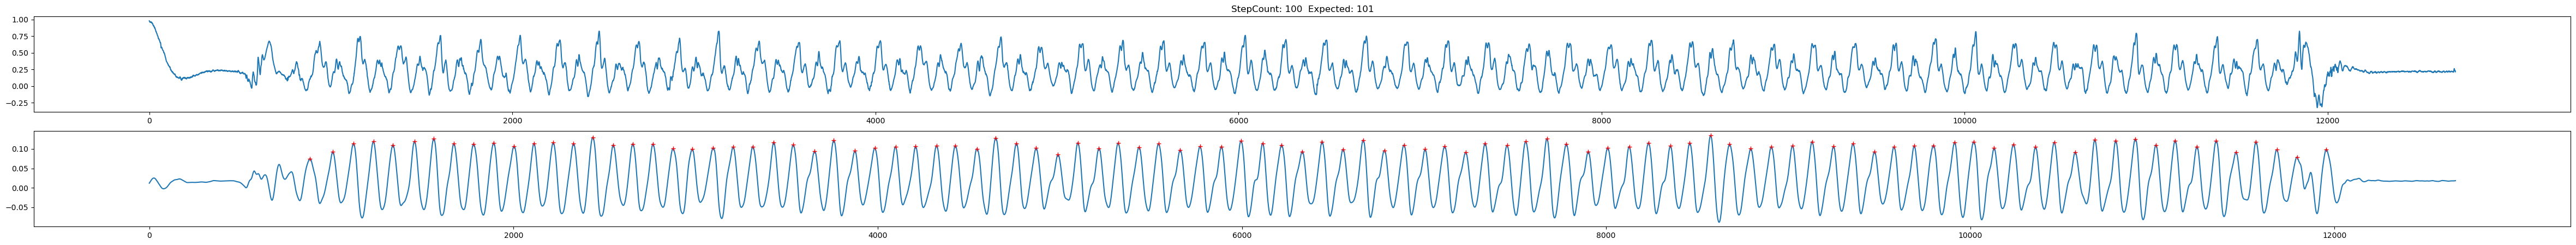

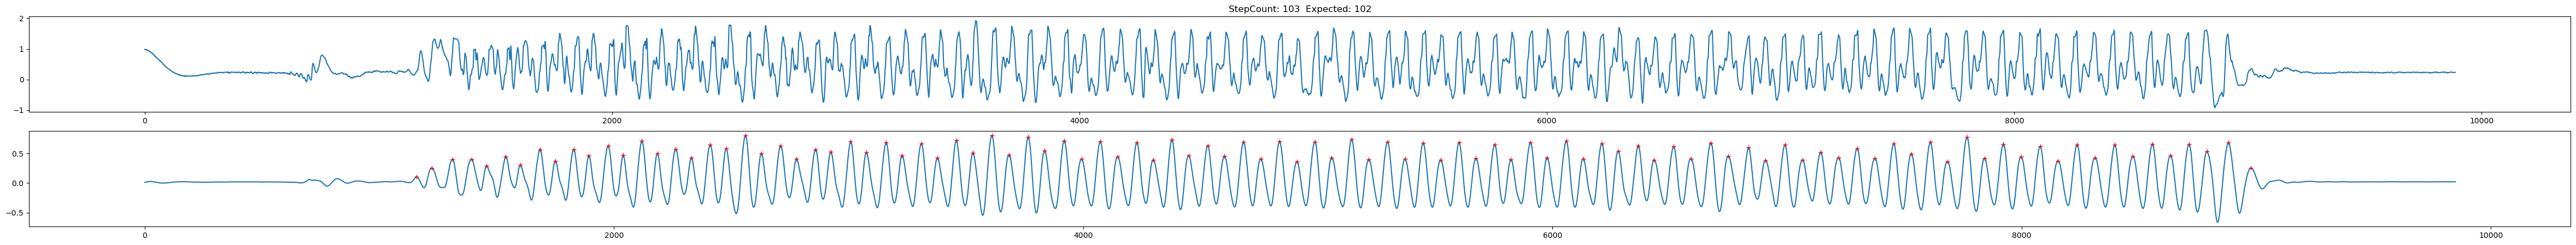

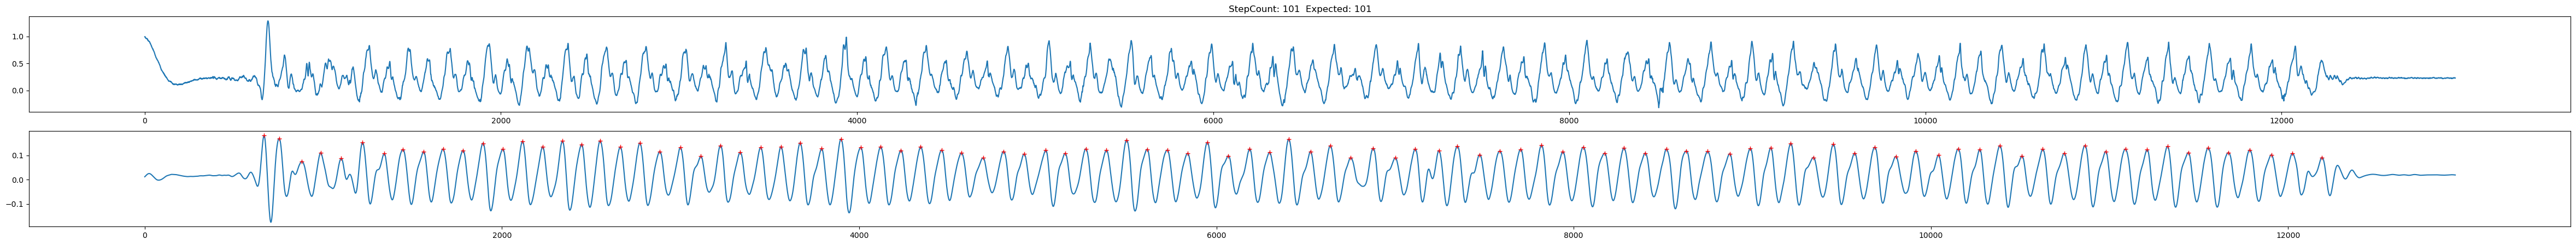

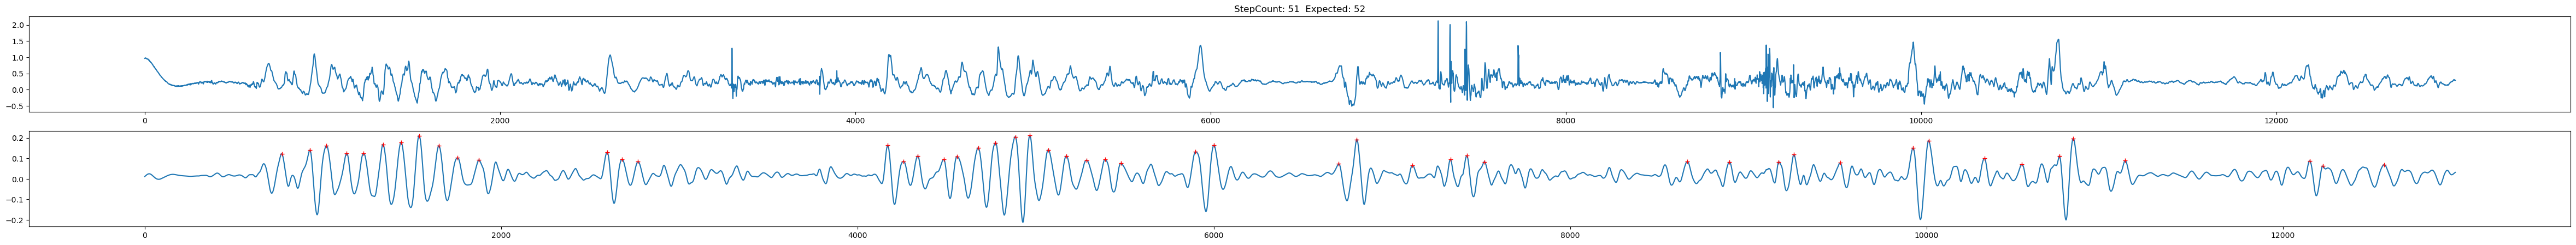

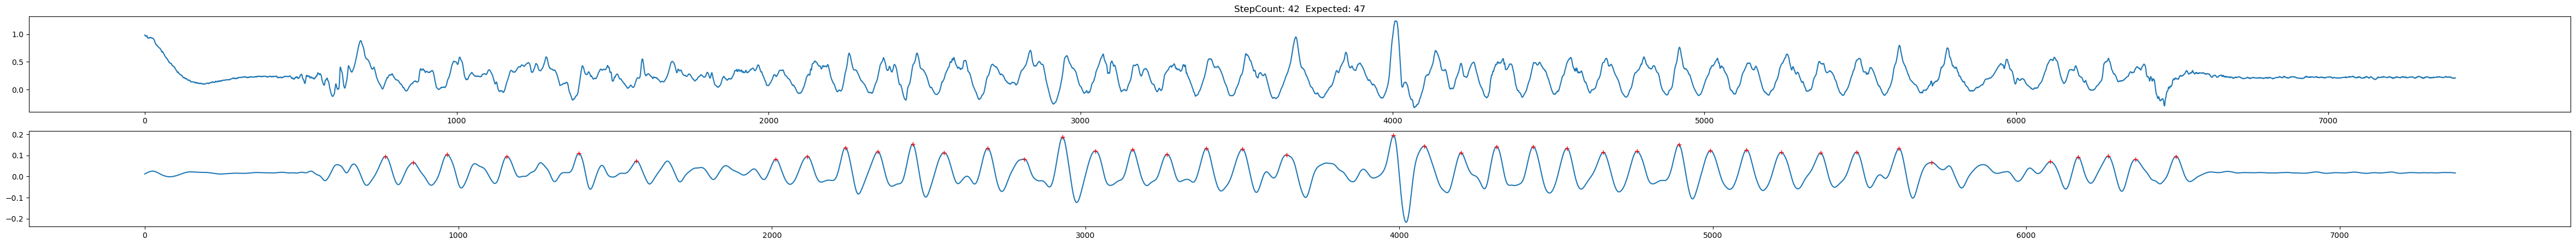

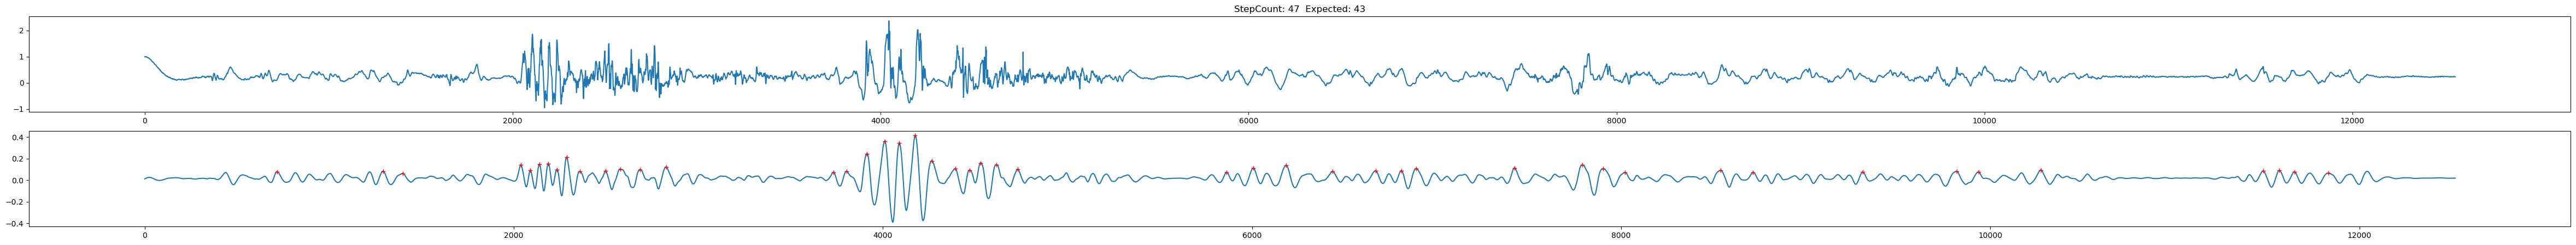

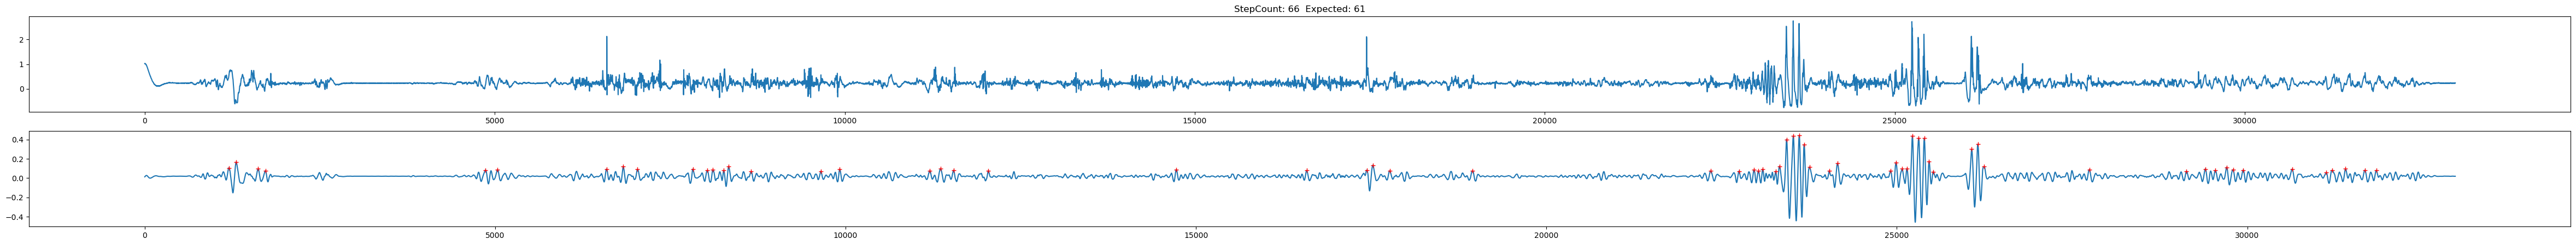

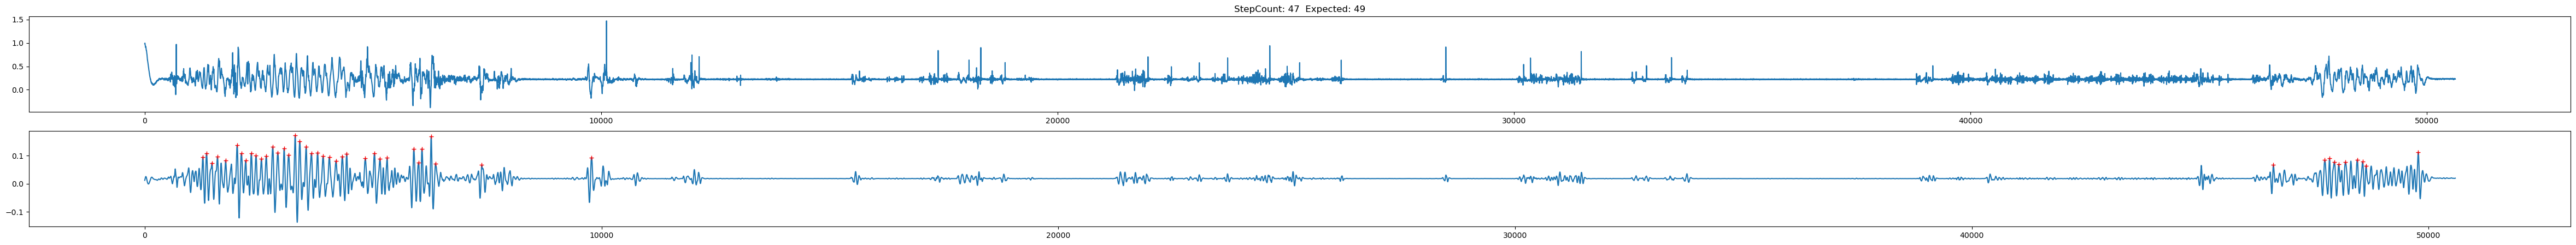

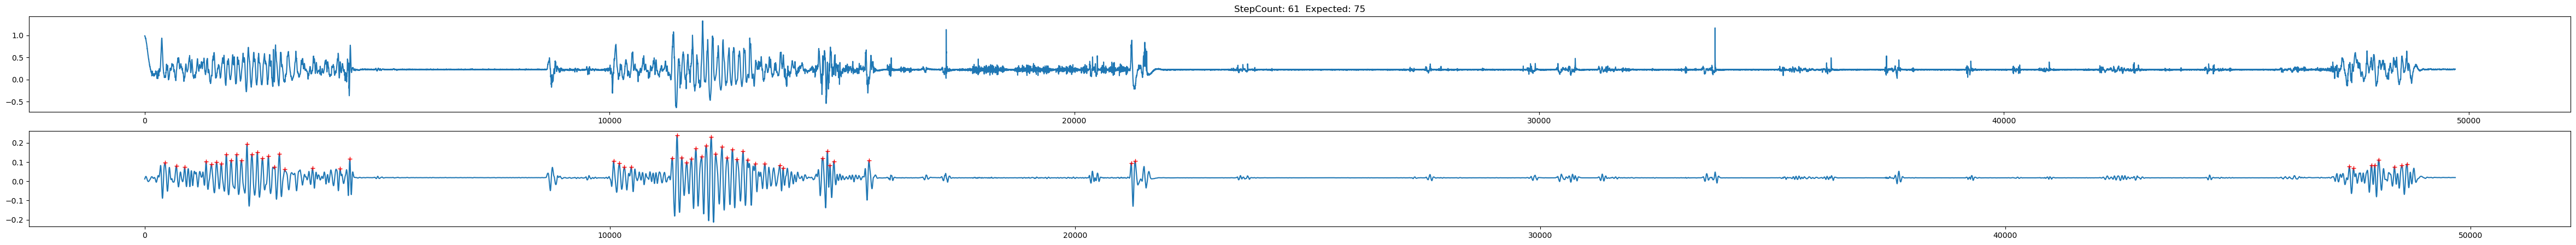

In [143]:
stepCounts = []
ids = []
diff = 0

for i, filename in enumerate(filenames):
    trace = Recording(filename, no_labels=True, mute=True)
    stepCount = 0

    # Your algorithm goes here
    # Make sure, you only use data from the LilyGo Wristband, namely the following 10 keys (as in trace.data[key]):
    # 3-axis accelerometer: key in [ax, ay, az]
    # 3-axis gyro: key in [gx, gy, gz]
    # 3-axis magnetometer: key in [mx, my, mz]
    # IMU temperature: key==temperature
    trace = Recording(filename, no_labels=True, mute=True)
    ax = trace.data['ax']
    ay = trace.data['ay']
    az = trace.data['az']
    
    timestamp_raw = ax.timestamps
    timestamp_ms = timestamp_raw*1000
    sampling_rate = len(timestamp_raw)/timestamp_raw[-1]

    # Calculate raw magnitude of accelerometer signal
    amagn = [sqrt(a**2+ay.values[i]**2+az.values[i]**2)for i, a in enumerate(ax.values)]
    trace.data['amagn'] = Dataset.fromLists('Accelerometer magnitude', amagn, timestamp_ms)

    # # Calculate raw magnitude of accelerometer signal
    # gmagn = [sqrt(g**2+gy.values[i]**2+gz.values[i]**2)for i, g in enumerate(gx.values)]
    # trace.data['gmagn'] = Dataset.fromLists('Accelerometer magnitude', gmagn, timestamp_ms)

    # sos = signal.butter(1, 1.5, 'lowpass', fs=sampling_rate, output='sos')
    # gmagn_lowpass_filter = signal.sosfilt(sos, gmagn)

    # # Detrend the signal
    # mag_detrended = sp.signal.detrend(amagn)
    # trace.data['amagn_detrended'] = Dataset.fromLists('Detrended Accelerometer magnitude', mag_detrended, trace.data['ax'].timestamps)



    # # Smoothing the signal -----------------------------------------------------------------------------------
    # # Denoise with convolution
    # filter_window_size = 55
    # mag_denoise = np.convolve(mag_detrended, np.ones((filter_window_size,))/filter_window_size, mode='valid')

    # # Find outliers

    # # Baseline correction
    # baseline, mag_aligned = baseline_err_medfilter(mag_denoise, sampling_rate)

    # # Normalization
    # mag_norm = normalize(mag_aligned, min_peak_height=0)




    # min_peak_height = 0.0
    # peak_locations, _ = get_peaks(mag_norm, min_peak_height)
    # stepCount = len(peak_locations)
    
    
    
    
    
    
    data_gravity = Filter.low_0_hz(amagn)
    data_user = amagn - data_gravity
    data_a = data_user*data_gravity
    data_filtered = Filter.low_5_hz(data_a)
    data_filtered = Filter.high_1_hz(data_filtered)
    filter_window_size = 40
    data_filtered = np.convolve(data_filtered, np.ones((filter_window_size,))/filter_window_size, mode='valid')
    
    prominence = 0.1
    peak_locations, _ = get_peaks(data_filtered, prominence)
    stepCount = len(peak_locations)
    
    
    
    title = "StepCount: " + str(stepCount) + "  Expected: " + str(labels_csv["Expected"][i])
    diff += np.abs(stepCount - int(labels_csv["Expected"][i]))
    diff = np.abs(stepCount - int(labels_csv["Expected"][i]))
    print(title)

    # print detected peak

    fig, axes1 = plt.subplots(2,1, figsize=(60, 5)) #figsize is width, height
    axes1[0].set_title(title)
    axes1[0].plot(data_user, alpha=1, label="original")
    # axes1[0].plot(mag_denoise, alpha=1, label="original")
    # axes1[0].plot(baseline, alpha=1, label="baseline")

    axes1[1].plot(data_filtered, alpha=1, label="Filtered mag")
    axes1[1].plot(peak_locations, data_filtered[peak_locations], 'y+', color="red", label="Peak Locations")



    # Append your calculated step counts and the id of the trace to the corresponding array
    stepCounts.append(stepCount)
    ids.append(filename.split('_')[1][:2])
print("Error: ", diff/10)

In [ ]:
# Write the detected step counts into a .csv file to then upload the .csv file to Kaggle
# When cross-checking the .csv file on your computer, we recommend using the text editor and NOT excel so that the results are displayed correctly
# IMPORTANT: Do NOT change the name of the columns ('Id' and 'Predicted') of the .csv file
df = pd.DataFrame({'Id':ids,'Predicted':stepCounts})
df.to_csv('./submission.csv', index=False)